In [1]:
# Copyright (c) 2022 Graphcore Ltd. All rights reserved.

%config Completer.use_jedi=False

import json
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import ogb.lsc
import pandas as pd
from typing import *
import wandb

import poplar_kge_ensemble


def flatten(d: Any, prefix: Tuple[str, ...] = ()) -> Iterable[Tuple[str, Any]]:
    if isinstance(d, dict):
        yield from ((kk, vv) for k, v in d.items() for kk, vv in flatten(v, prefix + (k,)))
    else:
        yield (".".join(prefix), d)


WANDB_API = wandb.Api(dict(
    base_url="https://wandb.sourcevertex.net",
    entity="ogb-wikiwiki",
    project="poplar-kge-v2",
))

DATA = ogb.lsc.WikiKG90Mv2Dataset("/home/research-datasets/ogb/lsc/")

# Submission

In [2]:
# Fetch run data & predictions from wandb

def load_predictions(ids: List[str]) -> Dict[str, np.ndarray]:
    cache_dir = Path("runs")
    all_predictions = {k: [] for k in ["valid", "test-dev", "test-challenge"]}
    for id_ in ids:
        run = WANDB_API.run(f"poplar-kge-v2/{id_}")
        assert run.state == "finished", f"run {id_} is not finished"
        run_dir = cache_dir / id_
        if not run_dir.exists():
            print(f"Syncing {id_:<30}", file=sys.stderr, end="\r")
            run_dir.mkdir()
            for file in run.files():
                if file._attrs["name"].startswith("predictions_"):
                    file.download(run_dir)
        predictions = np.load(run_dir / "predictions_final.npz")
        for part in all_predictions:
            all_predictions[part].append(predictions[part])
    return {k: np.stack(v) for k, v in all_predictions.items()}

def run_summary(run: wandb.apis.public.Run) -> Dict[str, Any]:
    return {
        "w.id": run.id,
        "w.name": run.name,
        "w.state": run.state,
        "w.notes": run.notes,
        "w.has_final_predictions": (run.state == "finished") and any(f.name == "predictions_final.npz" for f in run.files()),
        **{f"s.{k}": v for k, v in run.summary.items() if not k.startswith("_")},
        **dict(flatten(run.config, ("c",))),
    }

df = pd.DataFrame.from_dict([run_summary(run) for run in WANDB_API.runs(filters={"created_at": {"$lt": "2022-10-30T12:00:00"}})])
# Filter and fix "c.model.distance_fn"
df = df[~((df["c.model.score_fn"] == "ComplEx") & (df["c.model.distance_fn"] != "MatMul"))]
df.loc[(df["c.model.score_fn"] == "DistMult") & (df["c.model.distance_fn"] != "MatMul"), "c.model.distance_fn"] = "MatMul"

In [3]:
# Create ensemble

COUNT_BY_SCORE_FN = dict(
    TransE=25,
    TransH=5,
    RotatE=5,
    ComplEx=25,
    DistMult=25,
)
ENSEMBLE_SCORE_POWER = -0.5

runs_to_ensemble = (df
    .pipe(lambda d: d[d["w.has_final_predictions"]])
    .pipe(lambda d: d.groupby("c.model.score_fn")
        .apply(lambda g: g.sort_values("s.valid_mrr", ascending=False).head(COUNT_BY_SCORE_FN.get(g["c.model.score_fn"].iloc[0], 0)))
        .reset_index(drop=True))
)

predictions = {
    part: poplar_kge_ensemble.mean_ensemble(predictions, count=10, power=ENSEMBLE_SCORE_POWER)
    for part, predictions in load_predictions(runs_to_ensemble["w.id"]).items()
}

In [4]:
# Evaluate Valid MRR & save test submission

valid_mrr = ogb.lsc.WikiKG90Mv2Evaluator().eval({"h,r->t": {
    "t_pred_top10": predictions["valid"].astype(np.int32),
    "t": DATA.valid_dict["h,r->t"]["t"]
}})["mrr"]

!rm -r wikiwiki/

for part in ["test-dev", "test-challenge"]:
    ogb.lsc.WikiKG90Mv2Evaluator().save_test_submission({"h,r->t": {"t_pred_top10": predictions[part].astype(np.int32)}}, dir_path="wikiwiki", mode=part)

!sha256sum wikiwiki/*

82bf708ef47ae1940d66810939cac790746a2faf7fdc11798c4ed18e34de9e51  wikiwiki/t_pred_wikikg90m-v2_test-challenge.npz
efc4a55cd5b588fc9f6b5a3293caa0bb4163db6a869569fe091d88e940138587  wikiwiki/t_pred_wikikg90m-v2_test-dev.npz


In [5]:
# Submission metadata

def count_parameters() -> int:
    # Run: 22ry4y5k (warm-mountain-841)
    entity_embedding_size = 256
    relation_embedding_size = entity_embedding_size // 2

    entity_embedding_count = DATA.num_entities * entity_embedding_size
    relation_embedding_count = DATA.num_relations * relation_embedding_size
    feature_projection_count = 2 * DATA.num_feat_dims * entity_embedding_size
    
    return entity_embedding_count + relation_embedding_count + feature_projection_count

for k, v in [
    ("Validation performance", valid_mrr),
    ("Package version", ogb.version.__version__),
    ("Training hardware and time", "16 hours on an IPU-POD16 Classic (single model)"),
    ("Test inference hardware and time", f"101 seconds on an IPU-POD16 Classic (single model)"),
    ("List of optimised hyperparameters",
     "lr: [3e-4 - 3e-3* - 3e-2], batch_size: [256* - 512], share_feature_networks: [False*, True], loss.type: [logsigmoid*, softmax], ..."),
    ("Number of models ensembled", len(runs_to_ensemble)),
    ("Number of learnable parameters", format(count_parameters(), ","))
]:
    print(f"{k:>40} | {v}")

                  Validation performance | 0.29219308495521545
                         Package version | 1.3.4
              Training hardware and time | 16 hours on an IPU-POD16 Classic (single model)
        Test inference hardware and time | 101 seconds on an IPU-POD16 Classic (single model)
       List of optimised hyperparameters | lr: [3e-4 - 3e-3* - 3e-2], batch_size: [256* - 512], share_feature_networks: [False*, True], loss.type: [logsigmoid*, softmax], ...
              Number of models ensembled | 85
          Number of learnable parameters | 23,355,606,912


# Detail

In [6]:
!git rev-parse HEAD

c4b6b813eaeebb116c6994809f3959f60b1b23a6


In [7]:
print(json.dumps(list(runs_to_ensemble["w.id"])))

["1ymtu9ci", "m2929ykj", "unfk7pcq", "2908f7fl", "1aqtonow", "166cfd6d", "3n5ic18k", "3a5lz5wd", "3n8js75z", "1m7kjbll", "dii67pxy", "ujw96yd9", "7yu4bcnh", "wmnfg819", "3hgsarx7", "u9u8lsd9", "nm32b09t", "7l8qh0hz", "3uawgobe", "nelp97kv", "dvftdrn0", "3g03ayr3", "uxm2jxp2", "1w0yxyci", "lxrxmjov", "2pg8win9", "3u731n72", "cwvim27j", "tdutpixp", "2h7z7wbf", "38mdpez0", "3y2xhjrr", "d0sn0ctq", "tferkntd", "l2z6dd5m", "2knge74c", "xcymnily", "ccwt8cio", "eruuoa8h", "jw71uzc7", "31qt56am", "vpx0jn57", "286ot9lt", "2c0u8gtx", "3ptrtpbm", "2d7afm5g", "3f0dmdq2", "3vcazki2", "3w55xxh0", "1dcrxzs4", "22ry4y5k", "34jzc7sp", "13ftpjon", "3f9hlw0q", "3pmu98h2", "xddsgip6", "3fge8rlg", "203gouw9", "2gg0okrm", "3h6wjvcg", "as05j7os", "3dgyoowo", "2hx05sac", "363ka4q9", "2490q6iw", "2y5w33gk", "2607u4kt", "1g6j8zo4", "330p0g48", "m0n9dj3a", "2kx3d8ll", "8le0t3rh", "2em8fjq9", "doa4c0i9", "np0ow8w9", "3hmp955o", "3ui3672n", "1uhi00kb", "my857moy", "3lj3cby0", "3heg69po", "1zdkemzp", "q8h2ipht", "yh

,0
c.model.score_fn,
ComplEx,25
DistMult,25
RotatE,5
TransE,25
TransH,5


,0
c.model.distance_fn,
L1,24
L2,11
MatMul,50


,0
c.training.loss.type,
logsigmoid,37
softmax,46


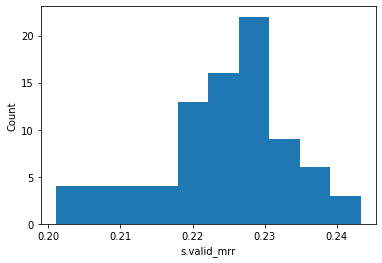

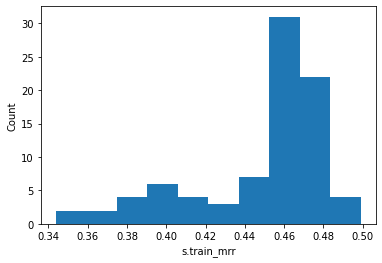

In [8]:
display(runs_to_ensemble.groupby("c.model.score_fn").apply(len).to_frame())
display(runs_to_ensemble.groupby("c.model.distance_fn").apply(len).to_frame())
display(runs_to_ensemble.groupby("c.training.loss.type").apply(len).to_frame())
for key in ["s.valid_mrr", "s.train_mrr"]:
    plt.figure()
    plt.hist(runs_to_ensemble[key])
    plt.xlabel(key)
    plt.ylabel("Count");

In [9]:
runs_to_ensemble.sort_values("s.valid_mrr", ascending=False).iloc[0].to_dict()

{'w.id': '22ry4y5k',
 'w.name': 'warm-mountain-841',
 'w.state': 'finished',
 'w.notes': None,
 'w.has_final_predictions': True,
 's.train_mrr': 0.4280286133289337,
 's.valid_mrr': 0.2432861626148224,
 's.compile_time': 686.360630273819,
 's.eval_train_time': 101.21137428283691,
 's.train_step_loop_time': 9.655645370483398,
 's.learning_rate': 0.003000000000000001,
 's.load_data_time': 16.66625213623047,
 's.initialise_time': 1534.2067091464996,
 's.build_index_time': 223.4641933441162,
 's.step': 5000000.0,
 's.loss': 0.10585989505052566,
 's.eval_valid_time': 100.96484351158142,
 's.sample': 20480000000.0,
 'c.data.seed': 2129884912.0,
 'c.data.dataset.name': 'wikikg90mv2',
 'c.data.a2a_size': 96.0,
 'c.data.batch_size': 256.0,
 'c.data.sample_weight': nan,
 'c.data.sampling_strategy.type': 'cubic_root',
 'c.data.triple_augmentation': nan,
 'c.data.entity_feature_mapping': 'full',
 'c.seed': 170339634.0,
 'c.model.seed': 935351688.0,
 'c.model.gamma': 10.0,
 'c.model.n_shard': 16.0,
